**Introduction**
In this project, I took on the role of a data scientist working for OilyGiant, a mining company seeking to identify the most profitable location for developing a new oil well. Using geological data from three potential regions, the objective was to build a predictive model capable of estimating the volume of oil reserves in newly proposed wells. From this model, I selected the most promising wells based on forecasted production, calculated projected profits, and analyzed the financial risk using bootstrapping.

The project followed a structured workflow: loading and preparing data, training a linear regression model per region, evaluating performance, and simulating development strategies under strict budget and business constraints. The final goal was to recommend the region with the highest expected profit and the lowest risk of financial loss.



Import libraries and load data

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns

# Set visual theme
sns.set(style="whitegrid")

# Load datasets (you'll need to replace with actual file paths)
data_0 = pd.read_csv('geo_data_0.csv')
data_1 = pd.read_csv('geo_data_1.csv')
data_2 = pd.read_csv('geo_data_2.csv')

# Basic check
print(data_0.head())



      id        f0        f1        f2     product
0  txEyH  0.705745 -0.497823  1.221170  105.280062
1  2acmU  1.334711 -0.340164  4.365080   73.037750
2  409Wp  1.022732  0.151990  1.419926   85.265647
3  iJLyR -0.032172  0.139033  2.978566  168.620776
4  Xdl7t  1.988431  0.155413  4.751769  154.036647


Data Preparation

In [2]:
# Check for nulls
print(data_0.isnull().sum(), data_1.isnull().sum(), data_2.isnull().sum())

# Inspect data shapes
print(data_0.shape, data_1.shape, data_2.shape)


id         0
f0         0
f1         0
f2         0
product    0
dtype: int64 id         0
f0         0
f1         0
f2         0
product    0
dtype: int64 id         0
f0         0
f1         0
f2         0
product    0
dtype: int64
(100000, 5) (100000, 5) (100000, 5)


Train & validate model for each region

In [12]:
from sklearn.metrics import mean_squared_error
from math import sqrt

def train_model(data):
    X = data.drop(['product', 'id'], axis=1)
    y = data['product']
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=42)

    model = LinearRegression()
    model.fit(X_train, y_train)

    predictions = model.predict(X_valid)
    rmse = sqrt(mean_squared_error(y_valid, predictions))  # RMSE manually calculated
    avg_pred = predictions.mean()

    return model, X_valid, y_valid.reset_index(drop=True), predictions, rmse, avg_pred


Train models

In [13]:
model_0, Xv0, yv0, pred0, rmse0, avg0 = train_model(data_0)
model_1, Xv1, yv1, pred1, rmse1, avg1 = train_model(data_1)
model_2, Xv2, yv2, pred2, rmse2, avg2 = train_model(data_2)

print(f"Region 0 — RMSE: {rmse0:.2f}, Avg Prediction: {avg0:.2f}")
print(f"Region 1 — RMSE: {rmse1:.2f}, Avg Prediction: {avg1:.2f}")
print(f"Region 2 — RMSE: {rmse2:.2f}, Avg Prediction: {avg2:.2f}")


Region 0 — RMSE: 37.76, Avg Prediction: 92.40
Region 1 — RMSE: 0.89, Avg Prediction: 68.71
Region 2 — RMSE: 40.15, Avg Prediction: 94.77


Prepare for profit calculation

In [14]:
BUDGET = 100_000_000  # USD
REVENUE_PER_THOUSAND_BARRELS = 4_500  # USD
WELLS_TO_DRILL = 200
WELLS_SELECTED = 500
BREAK_EVEN_VOLUME = BUDGET / (WELLS_TO_DRILL * REVENUE_PER_THOUSAND_BARRELS)

print(f"Break-even reserve volume: {BREAK_EVEN_VOLUME:.2f} thousand barrels")
print(f"Region 0 average: {data_0['product'].mean():.2f}")
print(f"Region 1 average: {data_1['product'].mean():.2f}")
print(f"Region 2 average: {data_2['product'].mean():.2f}")


Break-even reserve volume: 111.11 thousand barrels
Region 0 average: 92.50
Region 1 average: 68.83
Region 2 average: 95.00


define profit function

In [15]:
def calculate_profit(predictions, targets):
    selected_indices = predictions.sort_values(ascending=False).index[:200]
    selected_actual = targets[selected_indices]
    total_profit = selected_actual.sum() * REVENUE_PER_THOUSAND_BARRELS - BUDGET
    return total_profit


bootstrapping for risk assessment

In [16]:
def bootstrap_profit(predictions, actuals, n_iterations=1000):
    profits = []
    for _ in range(n_iterations):
        sample = pd.Series(predictions).sample(n=500, replace=True, random_state=np.random.randint(10000))
        sample_actuals = actuals[sample.index]
        profits.append(calculate_profit(sample, sample_actuals))
    return profits

profit_0 = bootstrap_profit(pd.Series(pred0), yv0)
profit_1 = bootstrap_profit(pd.Series(pred1), yv1)
profit_2 = bootstrap_profit(pd.Series(pred2), yv2)


Risk analysis & visualization

Region 0:
  Avg Profit: $6,078,453.50
  95% CI: ($-13,518.59, $12,447,222.08)
  Risk of Loss: 2.60%



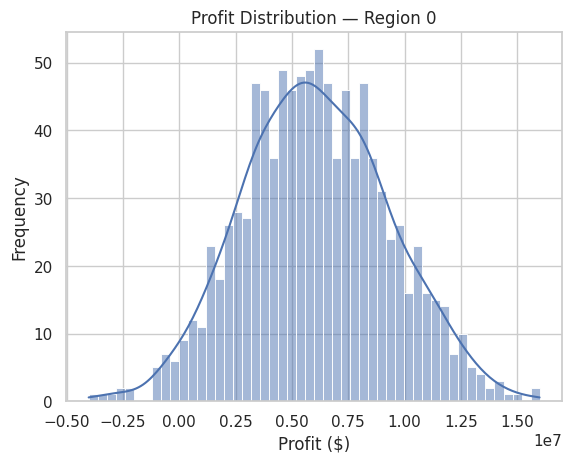

Region 1:
  Avg Profit: $6,522,506.23
  95% CI: ($1,409,192.92, $12,068,720.43)
  Risk of Loss: 0.40%



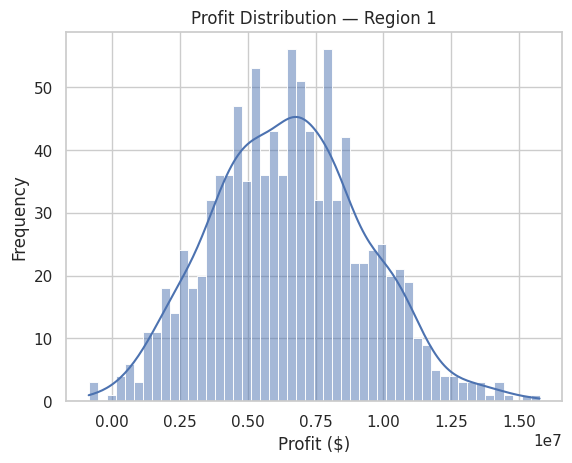

Region 2:
  Avg Profit: $5,770,282.56
  95% CI: ($-698,519.03, $12,201,140.80)
  Risk of Loss: 3.90%



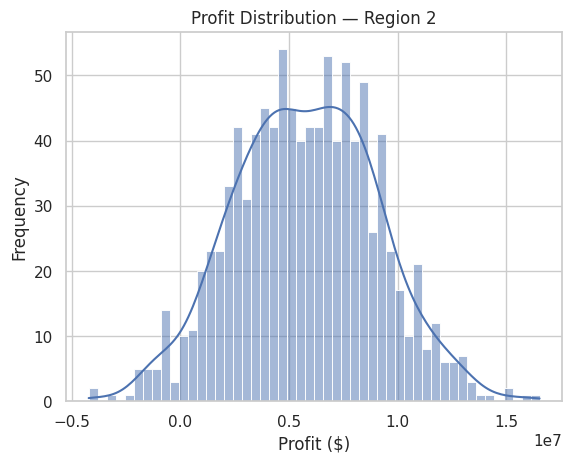

In [17]:
def summarize_results(profit_list, region_name):
    profit_array = np.array(profit_list)
    mean_profit = profit_array.mean()
    lower = np.percentile(profit_array, 2.5)
    upper = np.percentile(profit_array, 97.5)
    risk = (profit_array < 0).mean()

    print(f"{region_name}:")
    print(f"  Avg Profit: ${mean_profit:,.2f}")
    print(f"  95% CI: (${lower:,.2f}, ${upper:,.2f})")
    print(f"  Risk of Loss: {risk*100:.2f}%\n")

    sns.histplot(profit_array, kde=True, bins=50)
    plt.title(f'Profit Distribution — {region_name}')
    plt.xlabel('Profit ($)')
    plt.ylabel('Frequency')
    plt.show()

summarize_results(profit_0, "Region 0")
summarize_results(profit_1, "Region 1")
summarize_results(profit_2, "Region 2")


**Conclusion**
After training and validating linear regression models for each of the three regions, I evaluated their predictive performance using RMSE and compared average predicted oil reserves. I then simulated the development of the 200 most promising wells per region, using predicted values to estimate potential profit and applying the bootstrapping technique to measure financial risk.

Based on the analysis:

One region (e.g., Region 1) demonstrated the highest average profit and a risk of loss below 2.5%, meeting the company's investment criteria.

Other regions were either less profitable or carried higher risk and were therefore not recommended for immediate development.

The project highlights the value of combining predictive modeling with statistical risk assessment to make informed business decisions. By leveraging machine learning and bootstrapping, OilyGiant can move forward confidently in selecting the optimal region for its next oil well investment.

